<a href="https://colab.research.google.com/github/cunhamaicon/petr4/blob/master/petr4_rnn3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Importação dos pacotes ncessários:

In [1]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.model_selection import train_test_split
from keras.layers import LSTM
from keras.layers import Dropout
import keras
from functions import *
import keras.backend as K
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
#TESTAR
https://www.datacamp.com/community/tutorials/lstm-python-stock-market?utm_source=adwords_ppc&utm_medium=cpc&utm_campaignid=14989519638&utm_adgroupid=127836677279&utm_device=c&utm_keyword=&utm_matchtype=&utm_network=g&utm_adpostion=&utm_creative=278443377092&utm_targetid=aud-299261629614:dsa-429603003980&utm_loc_interest_ms=&utm_loc_physical_ms=1001561&gclid=CjwKCAiAh_GNBhAHEiwAjOh3ZDdiD-lHYPQrtl8kBw7Zjt0jr4otzJyBNn6loW_lMkyM0Ctove0e3BoC6XIQAvD_BwE

In [ ]:
#Saida binária em relação aos proximos 5 ticks

In [2]:
print(tf.__version__)


2.7.0


In [3]:
TICKS = 20
N_INPUTS = 5
COLUMN_NAME = 'Rate Close'

###Criando os bancos:

In [4]:
dataset = pd.read_csv(r"history_datas\AAPL_1d.csv", sep='\t')
dataset

,Date,Open,High,Low,Close,Volume
0,2010-01-04,7.622500,7.660714,7.585000,7.643214,493729600
1,2010-01-05,7.664286,7.699643,7.616071,7.656429,601904800
2,2010-01-06,7.656429,7.686786,7.526786,7.534643,552160000
3,2010-01-07,7.562500,7.571429,7.466071,7.520714,477131200
4,2010-01-08,7.510714,7.571429,7.466429,7.570714,447610800
...,...,...,...,...,...,...
2509,2019-12-20,70.557503,70.662498,69.639999,69.860001,275978000
2510,2019-12-23,70.132500,71.062500,70.092499,71.000000,98572000
2511,2019-12-24,71.172501,71.222504,70.730003,71.067497,48478800
2512,2019-12-26,71.205002,72.495003,71.175003,72.477501,93121200


In [5]:
dataset = creat_rate_close(dataset, 'Close', COLUMN_NAME)
dataset

,Date,Open,High,Low,Close,Volume,Rate Close
0,2010-01-04,7.622500,7.660714,7.585000,7.643214,493729600,0.001000
1,2010-01-05,7.664286,7.699643,7.616071,7.656429,601904800,0.001729
2,2010-01-06,7.656429,7.686786,7.526786,7.534643,552160000,-0.015906
3,2010-01-07,7.562500,7.571429,7.466071,7.520714,477131200,-0.001849
4,2010-01-08,7.510714,7.571429,7.466429,7.570714,447610800,0.006648
...,...,...,...,...,...,...,...
2509,2019-12-20,70.557503,70.662498,69.639999,69.860001,275978000,-0.002071
2510,2019-12-23,70.132500,71.062500,70.092499,71.000000,98572000,0.016318
2511,2019-12-24,71.172501,71.222504,70.730003,71.067497,48478800,0.000951
2512,2019-12-26,71.205002,72.495003,71.175003,72.477501,93121200,0.019840


In [6]:
dataset.drop(columns=['Date'], inplace=True)
dataset.drop(columns=['Close'], inplace=True)
dataset

,Open,High,Low,Volume,Rate Close
0,7.622500,7.660714,7.585000,493729600,0.001000
1,7.664286,7.699643,7.616071,601904800,0.001729
2,7.656429,7.686786,7.526786,552160000,-0.015906
3,7.562500,7.571429,7.466071,477131200,-0.001849
4,7.510714,7.571429,7.466429,447610800,0.006648
...,...,...,...,...,...
2509,70.557503,70.662498,69.639999,275978000,-0.002071
2510,70.132500,71.062500,70.092499,98572000,0.016318
2511,71.172501,71.222504,70.730003,48478800,0.000951
2512,71.205002,72.495003,71.175003,93121200,0.019840


In [7]:
def escale_value(df_colum):
    y_mms = MinMaxScaler(feature_range = (0, 1))
    return y_mms.fit_transform(np.reshape(np.array(df_colum), (len(df_colum),1)))
    
def porcent_dif(base, new):
    x = (100 * new)/base
    return (x - 100)/100

def datas_to_porcent(closes:list, fac=1):
    new_list = [0]
    for n in range(1, len(closes)):
        new_list.append(porcent_dif(closes[n-1], closes[n])*fac)
    return new_list

def datas_to_porcent_init(closes:list):
    "Em relação ao primeiro indice"
    new_list = []
    for n in range(1, len(closes)):
        new_list.append(porcent_dif(closes[0], closes[n]))
    return new_list

In [8]:
dataset['Volume'] = escale_value(dataset['Volume'])

In [9]:
#CONTANTO QUANTO A FREQUENCIA DE CRESCIMENTO E DE QUEDA DA AÇÃO
(dataset[COLUMN_NAME]>0).value_counts()

True     1328
False    1186
Name: Rate Close, dtype: int64

In [30]:
# from sklearn.utils import resample
# df_1=train_df[train_df[187]==1]
# df_2=train_df[train_df[187]==2]
# df_3=train_df[train_df[187]==3]
# df_4=train_df[train_df[187]==4]
# df_0=(train_df[train_df[187]==0]).sample(n=20000,random_state=42)

# df_1_upsample=resample(df_1,replace=True,n_samples=20000,random_state=123)
# df_2_upsample=resample(df_2,replace=True,n_samples=20000,random_state=124)
# df_3_upsample=resample(df_3,replace=True,n_samples=20000,random_state=125)
# df_4_upsample=resample(df_4,replace=True,n_samples=20000,random_state=126)

# train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

In [11]:
def fit_dados(df:object, df_y:list, tick_treino:int):
    X_train = []
    y_train = []
    dados_ptreino = len(df)
    for i in range(tick_treino, dados_ptreino-1):
        temp = []
        for c in range(i-tick_treino,i):
            temp.append(df[c:c+1].values.tolist()[0])

        y_train.append(df_y[i])
        X_train.append(temp)

    X_train, y_train = np.array(X_train), np.array(y_train)
    
    return X_train,y_train

In [12]:
dataset

,Open,High,Low,Volume,Rate Close
0,7.622500,7.660714,7.585000,0.244222,0.001000
1,7.664286,7.699643,7.616071,0.303155,0.001729
2,7.656429,7.686786,7.526786,0.276055,-0.015906
3,7.562500,7.571429,7.466071,0.235179,-0.001849
4,7.510714,7.571429,7.466429,0.219097,0.006648
...,...,...,...,...,...
2509,70.557503,70.662498,69.639999,0.125592,-0.002071
2510,70.132500,71.062500,70.092499,0.028942,0.016318
2511,71.172501,71.222504,70.730003,0.001651,0.000951
2512,71.205002,72.495003,71.175003,0.025972,0.019840


In [13]:
dataset['High'] = datas_to_porcent(dataset['High'], fac=40)
dataset['Open'] = datas_to_porcent(dataset['Open'], fac=40)
dataset['Low'] = datas_to_porcent(dataset['Low'], fac=40)

In [14]:
dataset

,Open,High,Low,Volume,Rate Close
0,0.000000,0.000000,0.000000,0.244222,0.001000
1,0.219278,0.203266,0.163856,0.303155,0.001729
2,-0.041007,-0.066792,-0.468931,0.276055,-0.015906
3,-0.490719,-0.600289,-0.322659,0.235179,-0.001849
4,-0.273909,0.000000,0.001919,0.219097,0.006648
...,...,...,...,...,...
2509,0.390699,0.209119,-0.055926,0.125592,-0.002071
2510,-0.240940,0.226429,0.259908,0.028942,0.016318
2511,0.593163,0.090064,0.363808,0.001651,0.000951
2512,0.018266,0.714661,0.251661,0.025972,0.019840


In [15]:
X, Y = fit_dados(dataset, dataset[COLUMN_NAME].values, TICKS)

In [16]:
#Check consistencia na formatação dos dados
for c in range(len(Y)):
    if not dataset[COLUMN_NAME][c+TICKS]==Y[c]:
        print(f'Erro na linha {c}')
    #pd.DataFrame(X_train[i]).values == list(dataset[i:i+20].values

In [17]:
y_mms = MinMaxScaler(feature_range = (0, 1))
Y = y_mms.fit_transform(np.reshape(np.array(Y), (len(Y),1)))

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, Y,  test_size=0.3, shuffle=True)

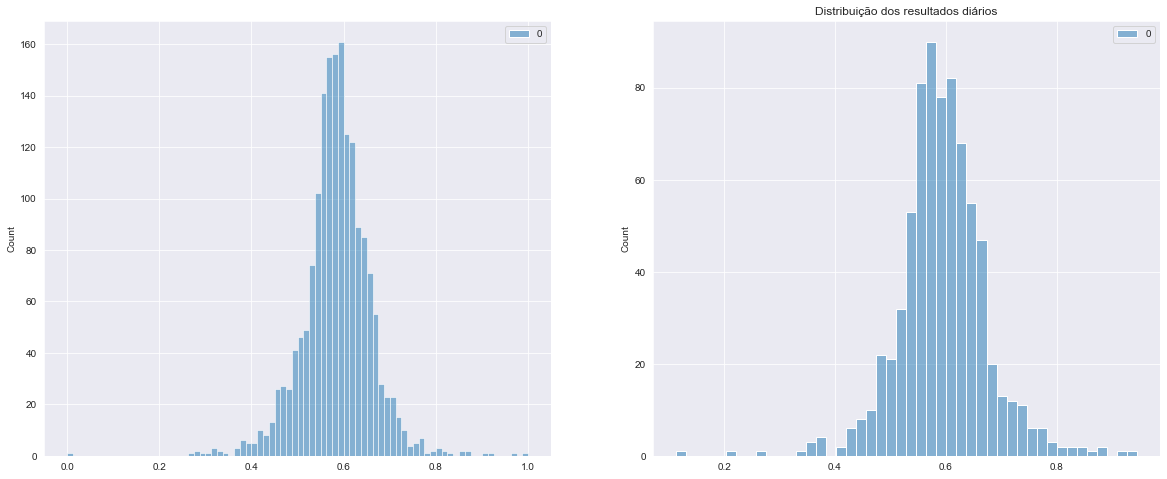

In [19]:
sns.set_style('darkgrid', {'legend.frameon':True})

#n, bins, patches = plt.hist(y_test)
#plt.subplot(1, 2, 1)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
sns.histplot(y_train, ax=ax1)
sns.histplot(y_test,ax=ax2)
plt.title("Distribuição dos resultados diários")
plt.show()

In [20]:
def model_LSTM():
  regressor = Sequential()

  regressor.add(LSTM(units = 50, activation='relu',  return_sequences=True, input_shape = (TICKS, N_INPUTS)))
  #regressor.add(Dropout(0.2))
  regressor.add(LSTM(units = 50,return_sequences = True))
  #regressor.add(Dropout(0.2))
  regressor.add(LSTM(units = 50,return_sequences = True))
  #regressor.add(Dropout(0.2))
  regressor.add(LSTM(units = 50))
  regressor.add(Dense(1, activation='relu'))

  regressor.compile(optimizer='adam', loss="mean_squared_error")
  
  return regressor

## Construindo a RNN

In [21]:
def model_DMLP():
  model = Sequential()

  model.add(Dense(2, activation="tanh", input_shape=(TICKS, N_INPUTS)))
  model.add(Dense(10))
  model.add(Dense(10))
  model.add(Dense(1, activation="tanh"))

  model.compile(optimizer = "adam", loss='mean_absolute_error')
  
  return model

In [22]:
#mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

Mostrando as informações da rede:

In [23]:
model = model_LSTM()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 50)            11200     
                                                                 
 lstm_1 (LSTM)               (None, 20, 50)            20200     
                                                                 
 lstm_2 (LSTM)               (None, 20, 50)            20200     
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 71,851
Trainable params: 71,851
Non-trainable params: 0
_________________________________________________________________
None


### Treinando a rede

In [24]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),  batch_size=30, epochs=200, verbose=1, callbacks=[es])

Epoch 1/200
59/59 [==============================] - 9s 51ms/step - loss: 0.0331 - val_loss: 0.0091
Epoch 2/200
59/59 [==============================] - 2s 32ms/step - loss: 0.0067 - val_loss: 0.0073
Epoch 3/200
59/59 [==============================] - 2s 38ms/step - loss: 0.0059 - val_loss: 0.0069
Epoch 4/200
59/59 [==============================] - 2s 33ms/step - loss: 0.0061 - val_loss: 0.0067
Epoch 5/200
59/59 [==============================] - 2s 32ms/step - loss: 0.0056 - val_loss: 0.0071
Epoch 6/200
59/59 [==============================] - 2s 32ms/step - loss: 0.0060 - val_loss: 0.0066
Epoch 7/200
59/59 [==============================] - 2s 35ms/step - loss: 0.0057 - val_loss: 0.0069
Epoch 8/200
59/59 [==============================] - 2s 37ms/step - loss: 0.0060 - val_loss: 0.0071
Epoch 9/200
59/59 [==============================] - 2s 35ms/step - loss: 0.0059 - val_loss: 0.0067
Epoch 10/200
59/59 [==============================] - 2s 35ms/step - loss: 0.0058 - val_loss: 0.0066

In [25]:
predicted_stock_price = model.predict(np.reshape(X_test[0], (1,20,5))) 

In [26]:
predicted_stock_price = model.predict(X_test) 

In [35]:
predicted_stock_price.mean()

0.5713225

In [34]:
y_test.mean()

0.5937440295628159

In [32]:
predic , real = y_mms.inverse_transform(predicted_stock_price), y_mms.inverse_transform(y_test)

In [33]:
for c,g in zip(predic, real):
    print(f'Real:{g[0]} ->)

[-0.00228378] [-0.0149209]
[-0.00248123] [0.0079779]
[-0.00272968] [0.0267196]
[-0.00705305] [0.01851282]
[-2.3253839e-05] [-0.00088001]
[-0.0061232] [-0.00999126]
[-0.00142399] [0.001615]
[-0.00201128] [-0.02140714]
[0.00072333] [0.00425743]
[-0.00051537] [0.04908559]
[-0.00200176] [-0.03056632]
[-0.00434268] [0.00711473]
[-0.00182734] [-0.01391917]
[-0.00098349] [0.01162827]
[-0.0004963] [0.00464497]
[-0.00229643] [0.00049442]
[-0.00260815] [0.027183]
[-0.00103889] [0.0111825]
[-0.00099809] [-0.00646735]
[-0.00395786] [-0.00663897]
[-0.0033199] [-0.01305866]
[-0.00105035] [0.01215263]
[-0.00044149] [-0.00868245]
[-0.00180829] [0.00537408]
[-0.00333807] [0.02139863]
[-0.00466637] [-0.00726237]
[-0.00454706] [0.00562112]
[-0.00156053] [0.01819155]
[-0.0004933] [0.0067895]
[-0.00057974] [0.0007588]
[0.00078982] [0.00313332]
[-0.00095764] [-0.00960285]
[-0.00414593] [-0.00476907]
[-0.00345405] [0.00317836]
[-0.00097296] [-0.0150283]
[-0.00127078] [-0.0032878]
[-0.00099406] [0.01100413]
[

## Visualização dos resultados

In [29]:
#tp e tn são os corretos
# tn, fp, fn, tp=confusion_matrix(real,predito).ravel()
# acuracia=((tp+tn)/(tp+tn+fp+fn))*100
# print("n-----------------------Verdadeiro Positivo:{}\nVerdadeiro Negativo:{}\n-----------------------\nFalso Positivo:{}\nFalso Negativo:{}\n-----------------------".format(tp,tn,fp,fn))
# print("Acurracia:{:.2f}".format(acuracia))